# 在自己的语义分割数据集上训练模型

同济子豪兄：https://space.bilibili.com/1900783

2022-10-18

## 进入 mmsegmentation 主目录

In [1]:
import os
os.chdir('mmsegmentation')

## 导入工具包

In [2]:
# import numpy as np
# import mmcv
# import time
# import shutil
# from mmseg.apis import inference_segmentor

## 下载数据集

In [3]:
# 下载
!wget http://dags.stanford.edu/data/iccv09Data.tar.gz -O standford_background.tar.gz

--2022-10-18 22:35:32--  http://dags.stanford.edu/data/iccv09Data.tar.gz
正在连接 172.16.0.13:5848... 已连接。
已发出 Proxy 请求，正在等待回应... 200 OK
长度： 14727974 (14M) [application/x-gzip]
正在保存至: “standford_background.tar.gz”

ford_background.tar 100%[===================>]  14.04M  1.72MB/s    用时 23s     

2022-10-18 22:35:58 (623 KB/s) - 已保存 “standford_background.tar.gz” [14727974/14727974])



In [4]:
# 解压
!tar xf standford_background.tar.gz

## 查看数据集中的图像

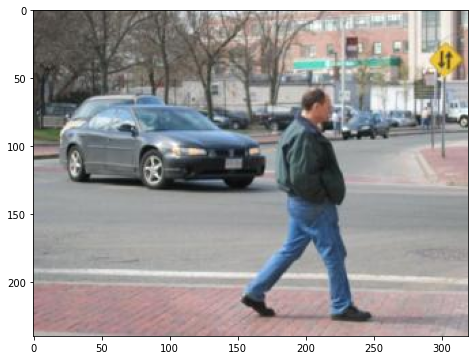

In [3]:
# 接着查看数据集
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('iccv09Data/images/6000124.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [4]:
import os.path as osp
import numpy as np
from PIL import Image

# 将原始数据转换成分割图
data_root = 'iccv09Data'
img_dir = 'images'
ann_dir = 'labels'

# 定义类别名和调色板
classes = ('sky', 'tree', 'road', 'grass', 'water', 'bldg', 'mntn', 'fg obj')
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34], 
           [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51]]

# 对每张图像从标注转换到分割图
for file in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.regions.txt'):
    seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
    seg_img = Image.fromarray(seg_map).convert('P')
    seg_img.putpalette(np.array(palette, dtype=np.uint8))
    seg_img.save(osp.join(data_root, ann_dir, file.replace('.regions.txt', '.png')))

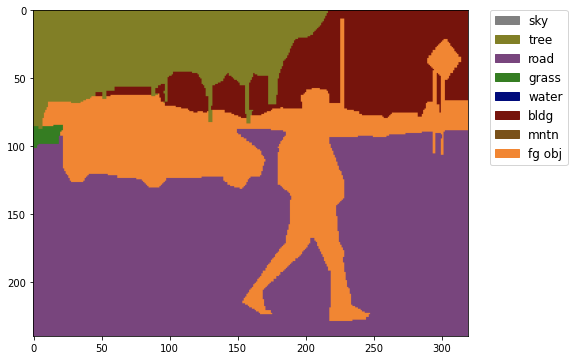

In [5]:
# 可视化分割图
import matplotlib.patches as mpatches
img = Image.open('iccv09Data/labels/6000124.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# 为每一种颜色创建一个图例
patches = [mpatches.Patch(color=np.array(palette[i])/255.,label=classes[i]) for i in range(8)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize='large')

plt.show()

In [6]:
# 随机切分训练和验证数据集 
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # 选择前 4/5 作为训练集
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # 选择后 1/5 作为验证集
  f.writelines(line + '\n' for line in filename_list[train_length:])

In [7]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class StandfordBackgroundDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

    

### 创建配置文件

接下来，修改配置文件进行训练。为了加速训练过程，我们使用模型微调。

In [8]:
from mmcv import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')

上面使用的配置文件是基于 cityscapes 数据集训练的 PSPNet 模型。我们需要根据我们的新数据集对这个配置文件进行修改。

In [17]:
from mmseg.apis import set_random_seed

# 使用单个 GPU ，所以使用 BN 而非 SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

# 修改模型 decode 和 auxiliary 头中类别的数量
cfg.model.decode_head.num_classes = 8
cfg.model.auxiliary_head.num_classes = 8

# 修改 dataset_type 和路径数据路径 data_root
cfg.dataset_type = 'StandfordBackgroundDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 2

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# 使用 pspnet 的预训练模型权重
# cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'
cfg.load_from = 'checkpoint/pspnet_r50-d8_512x1024_80k_cityscapes_20200606_112131-2376f12b.pth'

# 设定文件和日志保存路径 work_dir
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# 设定 seed 去辅助模型训练
cfg.seed = 0
cfg.device = 'cuda'
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# 最后输出配置文件内容
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True,
        pretrained='open-mmlab://resnet50_v1c'),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=8,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=

## 训练和验证

In [18]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# 构建数据集
datasets = [build_dataset(cfg.data.train)]

# 构建模型
model = build_segmentor(cfg.model)

# 将类别名增加到模型中，便于进行可视化
model.CLASSES = datasets[0].CLASSES

# 创建 work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

2022-10-18 22:50:44,938 - mmseg - INFO - Loaded 572 images


AssertionError: EncoderDecoder: both backbone and segmentor set pretrained weight

## 预测

In [ ]:
img = mmcv.imread('iccv09Data/images/6000124.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

# 为每一种颜色创建一个 patch 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(8)]
# 将各种颜色的 patches 作为 Legen 图例中的参数 handles 输入
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()